# Analyze Kepler Data

### Imports

In [1]:
from astroquery.mast import Observations
from astropy.io import fits
from astropy.wcs import WCS
from astropy import log
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import logging

log.setLevel(logging.WARNING)

### Set Star and Project

In [2]:
star = "EPIC 201497682"  # input("What star would you like to look at?")
project = "hlsp_everest"  # hlsp_everest # input("Whose data do you want?")

### Kepler Definitions

For `everest` data quality and header info see https://archive.stsci.edu/prepds/everest/doc/build/v2/html/fitsfiles.html#lightcurve-hdu

List of Kepler K2 data quality flags from https://gist.github.com/barentsen/9b5a7b51f48e026e3af5

    "1": "Attitude tweak",
    "2": "Safe mode",
    "4": "Coarse point",
    "8": "Earth point",
    "16": "Zero crossing",
    "32": "Desaturation event",
    "64": "Argabrightening",
    "128": "Cosmic ray",
    "256": "Manual exclude",
    "1024": "Sudden sensitivity dropout",
    "2048": "Impulsive outlier",
    "4096": "Argabrightening",
    "8192": "Cosmic ray",
    "16384": "Detector anomaly",
    "32768": "No fine point",
    "65536": "No data",
    "131072": "Rolling band",
    "262144": "Rolling band",
    "524288": "Possible thruster firing",
    "1048576": "Thruster firing"


`get_lc()` 
retrieves desired data from MAST archive.

In [3]:
def get_lc(star, project):
    # Make sure that there are data for the criteria
    obs_count = Observations.query_criteria_count(
        obs_collection="K2",
        dataproduct_type=["timeseries"],
        instrument_name="Kepler",
        objectname=star,
        project=project
    )
    if obs_count == 0:
        raise RuntimeError("No data found in archive.")

    obs_table = Observations.query_criteria(
        obs_collection="K2",
        dataproduct_type=["timeseries"],
        instrument_name="Kepler",
        objectname=star,
        project=project
    )
    
    data_products = Observations.get_product_list(obs_table)
    lc_mask = ["lightcurve" in x or "light curve" in x for x in map(str.lower, data_products['description'])]
    if not any(lc_mask):
        raise RuntimeError("Retrieved data products do not contain light curve data.")
    
    data_products = data_products[lc_mask]  # keep only rows with light curves
    manifest = Observations.download_products(data_products)
    files = list(manifest['Local Path'])  # get local file names
    
    return files, data_products, obs_table

`bits_to_mask()` computes a mask from bit numbers (0-based).

In [4]:
def bits_to_mask(bits):
    return sum(1 << (bit - 1) for bit in bits)

`plot_lc()` creates plot (with or without "bad" data) based on the project type

In [15]:
def plot_lc(lc_data, project, use_quality=True):
    if isinstance(lc_data, str):
        lc_data = fits.getdata(lc_data, ext=1)
    
    if project == "k2":
        raw_flux = lc_data['SAP_FLUX']
        cor_flux = lc_data['PDCSAP_FLUX']
        quality = lc_data['SAP_QUALITY']
        time = lc_data['TIME']
        dq_bits = list(range(1, 22))  # [1, 2, 3, 4, 5, 6, 8, 10, 12]
        
    elif project == "hlsp_everest":
        raw_flux = lc_data['FRAW']
        cor_flux = lc_data['FLUX']
        quality = lc_data['QUALITY']
        time = lc_data['TIME']
        dq_bits = list(range(1, 22)) + [23, 24, 25]   # [1, 2, 3, 4, 5, 6, 8, 10, 12, 13, 14, 20, 23, 24, 25]
        
    elif project == "hlsp_k2sff":
        raw_flux = lc_data['FRAW']
        cor_flux = lc_data['FCOR']
        quality = lc_data['QUALITY']
        time = lc_data['T']
        dq_bits = [1, 2, 3, 4, 5, 6, 8, 10, 12]
    
    else:
        raise ValueError("Unknown project.")
    
    if use_quality:
        dq_mask = bits_to_mask(dq_bits)
        mask = np.logical_not(np.bitwise_and(quality, dq_mask))  # good data mask
        raw_flux = raw_flux[mask]
        cor_flux = cor_flux[mask]
        time = time[mask]
        
    fig = plt.figure(figsize=(11, 4))
    fig.add_subplot(211)

    plt.plot(time, raw_flux, '.', label='SAP')
    plt.legend(loc='lower left')
    #plt.ylim(np.nanmin(uncor_flux), np.nanmax(uncor_flux))

    fig.add_subplot(212)
    plt.plot(time, cor_flux, '.', label='PDC')
    plt.legend(loc='lower left')
    plt.xlabel('TIME (BTJD)')
    #plt.ylim(np.nanmin(cor_flux), np.nanmax(cor_flux))

In [6]:
data_files, data_prod, _ = get_lc(star, project)
# print(data_prod.colnames)
# data_prod['obsID', 'productFilename', 'description']

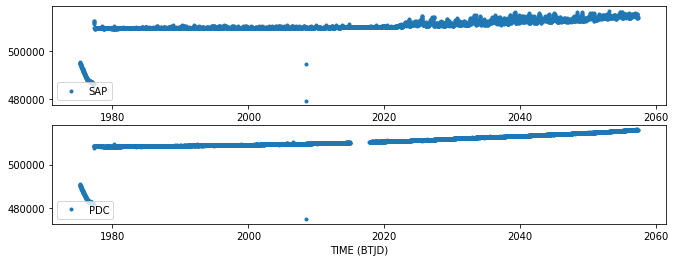

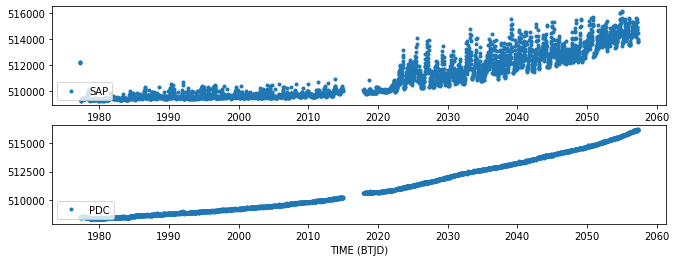

In [12]:
# Let's test it out
plot_lc(data_files[0], project, False)
plot_lc(data_files[0], project, True)

In [16]:
'''
No longer used? 

fluxcent_col = lcdata['MOM_CENTR1']
fluxcent_row = lcdata['MOM_CENTR2']
distance = ((fluxcent_col-np.nanmean(fluxcent_col))**2 + (fluxcent_row-np.nanmean(fluxcent_row))**2)**(0.5)

mom_dump = np.bitwise_and(quality, 2**5) >= 1 

plt.figure(figsize = (11,5))
plt.plot(time[~bad_data], distance[~bad_data], '.', label = "mom_centr distance")
plt.vlines(time[mom_dump], 0,.1, colors = 'r', label = "Momentum Dump")
plt.xlabel('TIME(BTKD)')
plt.legend(loc = "upper left")
'''

'\nNo longer used? \n\nfluxcent_col = lcdata[\'MOM_CENTR1\']\nfluxcent_row = lcdata[\'MOM_CENTR2\']\ndistance = ((fluxcent_col-np.nanmean(fluxcent_col))**2 + (fluxcent_row-np.nanmean(fluxcent_row))**2)**(0.5)\n\nmom_dump = np.bitwise_and(quality, 2**5) >= 1 \n\nplt.figure(figsize = (11,5))\nplt.plot(time[~bad_data], distance[~bad_data], \'.\', label = "mom_centr distance")\nplt.vlines(time[mom_dump], 0,.1, colors = \'r\', label = "Momentum Dump")\nplt.xlabel(\'TIME(BTKD)\')\nplt.legend(loc = "upper left")\n'

In [10]:
#data_files

['./mastDownload/K2/everest201486605-c01_lc/hlsp_everest_k2_llc_201486605-c01_kepler_v2.0_lc.fits',
 './mastDownload/K2/everest201488455-c01_lc/hlsp_everest_k2_llc_201488455-c01_kepler_v2.0_lc.fits',
 './mastDownload/K2/everest201488486-c01_lc/hlsp_everest_k2_llc_201488486-c01_kepler_v2.0_lc.fits',
 './mastDownload/K2/everest201489877-c01_lc/hlsp_everest_k2_llc_201489877-c01_kepler_v2.0_lc.fits',
 './mastDownload/K2/everest201490938-c01_lc/hlsp_everest_k2_llc_201490938-c01_kepler_v2.0_lc.fits',
 './mastDownload/K2/everest201491139-c01_lc/hlsp_everest_k2_llc_201491139-c01_kepler_v2.0_lc.fits',
 './mastDownload/K2/everest201491499-c01_lc/hlsp_everest_k2_llc_201491499-c01_kepler_v2.0_lc.fits',
 './mastDownload/K2/everest201491688-c01_lc/hlsp_everest_k2_llc_201491688-c01_kepler_v2.0_lc.fits',
 './mastDownload/K2/everest201496678-c01_lc/hlsp_everest_k2_llc_201496678-c01_kepler_v2.0_lc.fits',
 './mastDownload/K2/everest201496714-c01_lc/hlsp_everest_k2_llc_201496714-c01_kepler_v2.0_lc.fits',


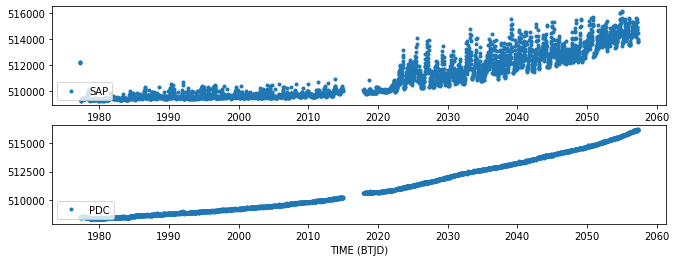

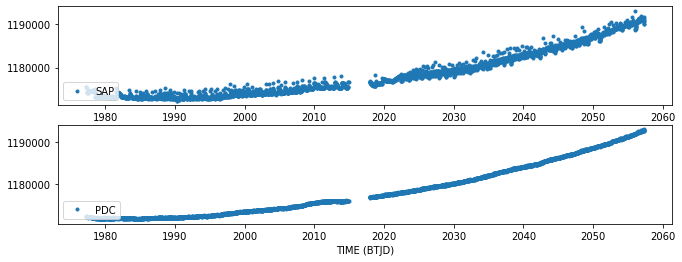

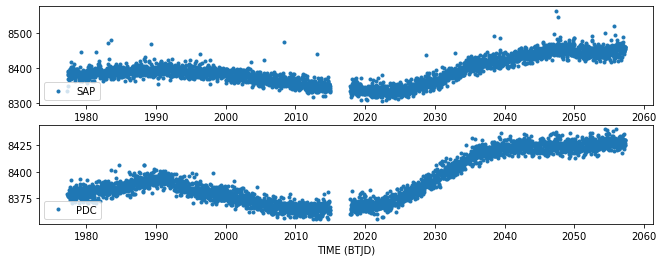

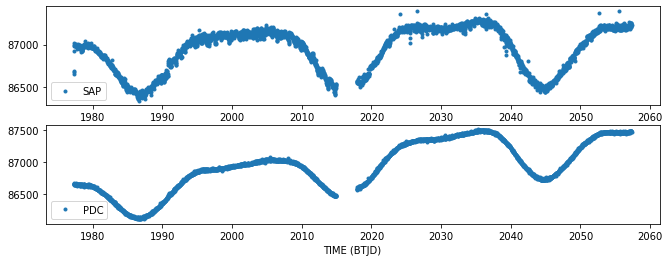

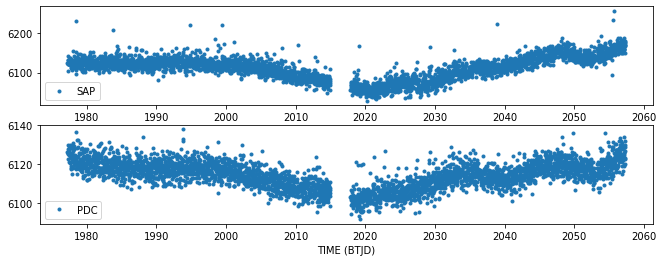

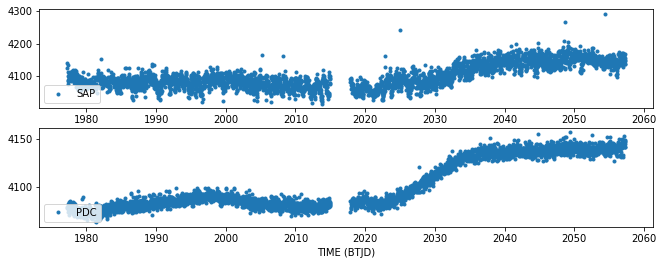

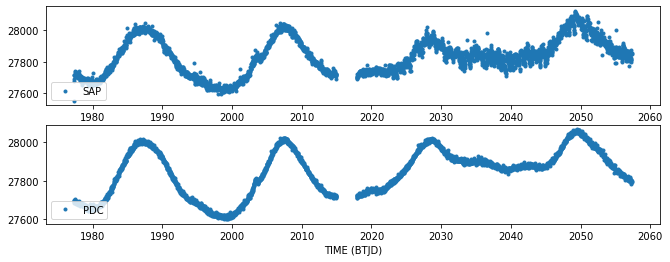

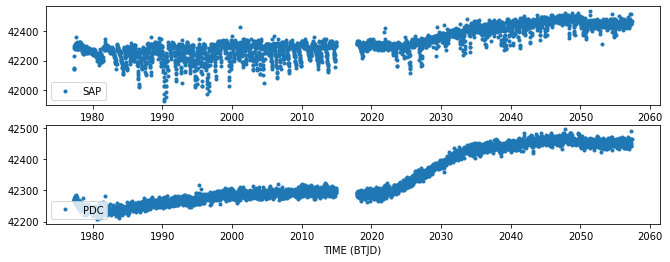

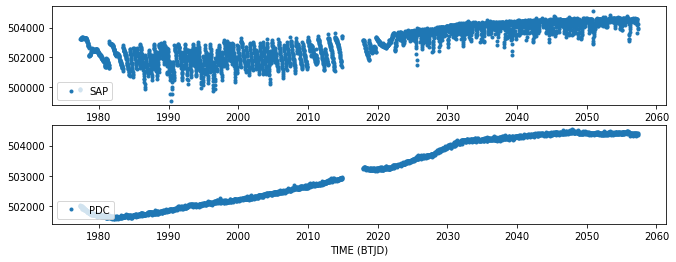

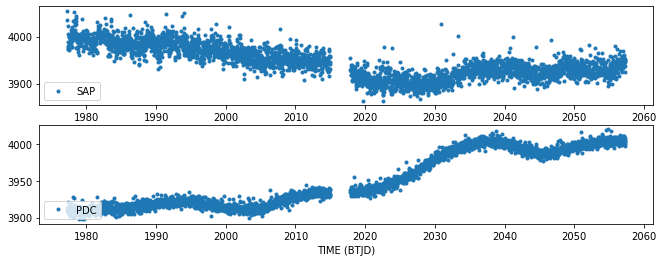

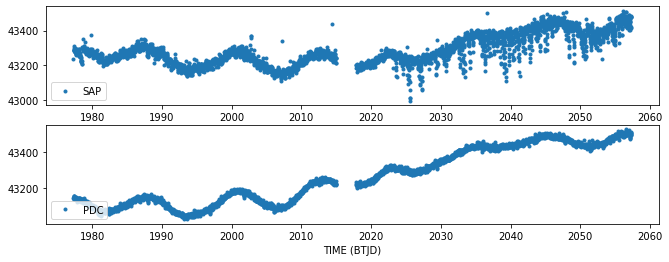

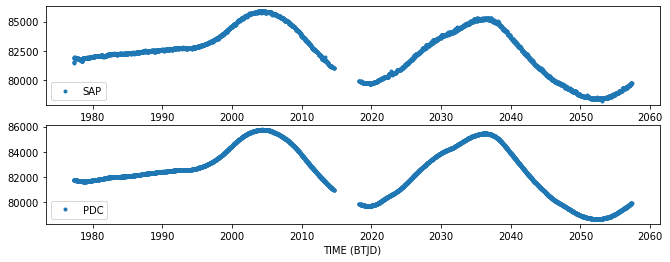

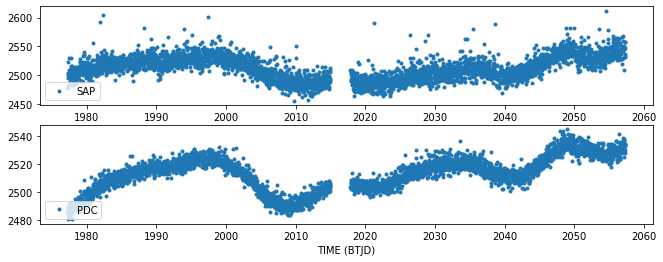

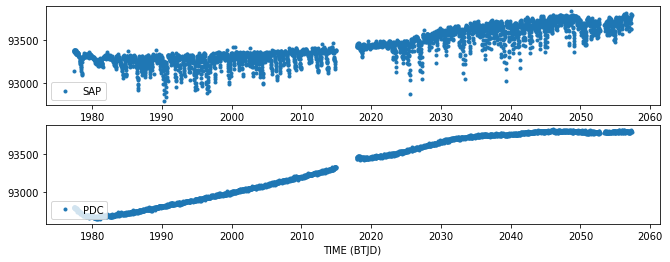

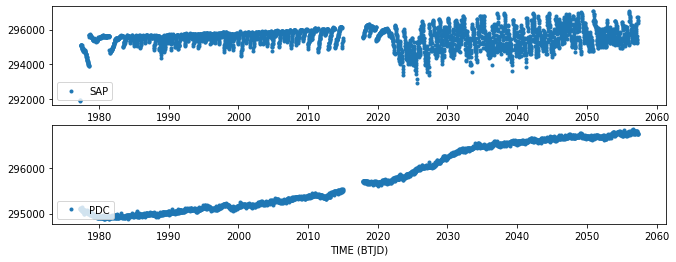

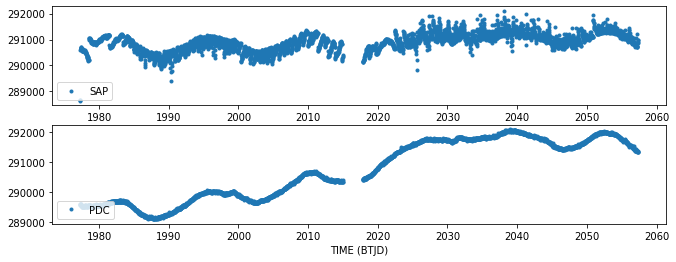

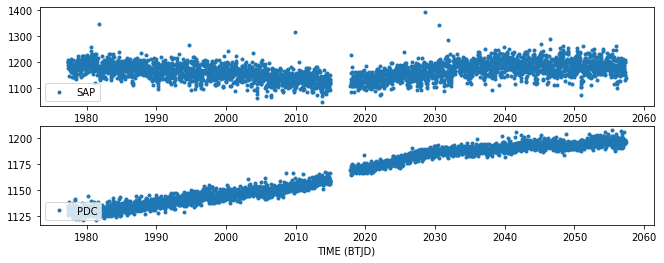

In [13]:
# Plot all of the files
for file_name in data_files:
    plot_lc(file_name, project, True)